# Coding Exercise 4: Job Search with Separation and Stochastic Offers

## Question 1: Discrete and IID Wage Offers



### The model

An unemployed worker receives with a probability $0 < \gamma < 1$ a wage offer $ w_t $, where $ \{w_t\} $ is IID and is drawn from a publicly known probability distribution $ q(w) $ from a set finite set $\mathbb{W} $ at each point in time.

Once receiving an offer at time $ t $, the unemployed worker has two options:

1. Accept the offer and work at constant wage $ w_t $ until she gets laid off.  
1. Reject the offer, receive unemployment compensation $ c $, and reconsider next period.  

Each period an employed worker faces a probability $\alpha$ of getting laid off and becoming unemployed. 

The agent is infinitely lived and aims to maximize the expected discounted sum of earnings

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t
$$

where 
- $ \beta \in (0, 1) $ is the discount factor.
- $ y_t $ is income, equal to
    - his/her wage $ w_t $ when employed  
    - unemployment compensation $ c $ when unemployed  

Let's denote $ V(w) $ and $ U $ the value of being employed at wage $w$ and the value of being unemployed, respectively. Then 

<a id='value_V'></a>
$$
V(w) = u(w) + \beta \Big[ (1-\alpha)V(w) + \alpha U \Big] \tag{1}
$$

and

<a id='value_U'></a>
$$
U = u(c) + \beta \left[(1-\gamma) U + \gamma \sum_{w' \in \mathbb W} \max\left\{V(w'), U\right\} q(w') \right] \tag{2}
$$


### Q.1-0: Import all external libraries that will used below.
    
- `numpy`, `numba`, `matplotlib` as usual
- `binom` from scipy.stats to generate wage offer distribution function in Q.1
- `brentq` from quantecon.optimize to solve the reservation wage in Q.2 

In [1]:
# your code here
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import binom
from quantecon.optimize import brentq
from numba import njit, prange, float64, int32
from numba.experimental import jitclass

### Q.1-1: Generate wage offer distribution

Suppose that the wage offers from a binomial distribution $B(n,p)$ with $n=50$ and $p=0.5$. Also assume that the set of possible wage offers has $n+1$ elements with the lowest wage is 10 and the highest wage is 40.

- Generate a vector `w` for wage offers and `q` for the probability for each wage offer. 
- plot `q` against `w`.

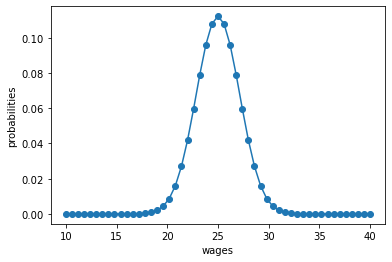

In [2]:
# your code here
n = 50                                  # n possible outcomes for w
p = 0.5
wmin = 10
wmax = 40
w = np.linspace(wmin, wmax, n+1)    # wages between 10 and 40
q = binom.pmf(range(n+1),n, p)

fig, ax = plt.subplots()
ax.plot(w, q, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()


### Q.1-2: Define the Class for the Model Economy

- specify types of the variables that are used in the class in `mccall_data`
- a function `__init__`: sets the default values for the data.
    - $\alpha = 0.1$: job separation rate
    - $\beta = 0.98$: discount factor
    - $\gamma = 0.7$: offer arrival rate
    - $\sigma = 2$: CRRA parameter
    - $c = 6$: unemployment compensation
- a function `u`: computes CRRA utility with parameter $\sigma$
- a function `update`: take V and U in the current as inputs and updates them according to equation (1) and (2) 
- jit-compile the class with `@jitclass`


In [3]:
# your code here
mccall_data = [
    ('α', float64),      # job separation rate
    ('β', float64),      # discount factor
    ('γ', float64),      # offer arrival rate
    ('c', float64),      # unemployment compensation
    ('σ', float64),      # RRA parameter
    ('w_vec', float64[:]),   # list of wage values
    ('q_vec', float64[:])    # pmf of random variable w
]

@jitclass(mccall_data)
class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self,
                α=0.1,       # Job separation rate
                β=0.98,      # Discount rate
                γ=0.7,       # Job offer rate
                c=6.0,       # Unemployment compensation
                σ=2.0,       # Utility parameter
                w_vec=w,  # Possible wage values
                q_vec=q): # Probabilities over w_vec

        self.α, self.β, self.γ, self.c = α, β, γ, c
        self.σ = σ
        self.w_vec = w_vec
        self.q_vec = q_vec
        

    def u(self, c, σ):
        if c > 0:
            return (c**(1 - σ) - 1) / (1 - σ)
        else:
            return -10e6
    
    
    def update(self, V, U):
        """
        A jitted function to update the Bellman equations.  Note that V_new is
        modified in place (i.e, modified by this function).  The new value of U
        is returned.

        """
        α, β, γ, c, σ, w_vec, q_vec = self.α, self.β, self.γ, self.c, self.σ, self.w_vec, self.q_vec
        u = self.u
        V_new = np.empty_like(V)     # To store updates to V
        for w_idx, w in enumerate(w_vec):
        # w_idx indexes the vector of possible wages
            V_new[w_idx] = u(w, σ) + β * ((1 - α) * V[w_idx] + α * U)

        U_new = u(c, σ) + β * (1 - γ) * U + \
                        β * γ * np.sum(np.maximum(U, V) * q_vec)

        return V_new, U_new



### Q.1-3: Solve Value Functions through Iteration

- Write a function `solve_model` that iterates the value functions V and U until they converge to their fixed points.
- jit-compile the function with `@njit`
- Create an instance `mcm` of the class `McCallModel` with the default values.
- solve for the fixed points of V and U.
- plot the converged V and U.


In [4]:
# your code here
@njit
def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    Parameters
    ----------
    mcm : an instance of McCallModel
    tol : float
        error tolerance
    max_iter : int
        the maximum number of iterations
    """

    V = np.ones(len(mcm.w_vec))  # Initial guess of V
    U = 1                        # Initial guess of U
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        V_new, U_new = mcm.update(V, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1

    return V, U

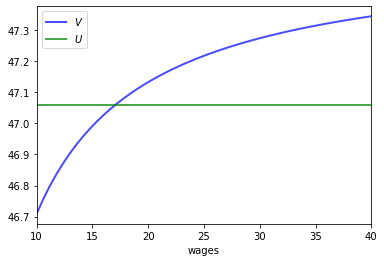

In [5]:
mcm = McCallModel()
V, U = solve_model(mcm)

fig, ax = plt.subplots()

ax.plot(mcm.w_vec, V, 'b-', lw=2, alpha=0.7, label='$V$')
ax.plot(mcm.w_vec, [U] * len(mcm.w_vec), 'g-', lw=2, alpha=0.7, label='$U$')
ax.set_xlim(min(mcm.w_vec), max(mcm.w_vec))
ax.set_xlabel('wages')
ax.legend()

plt.show()

### Q.1-4: Reservation Wage

- Write a function `compute_reservation_wage` to compute the reservation wage for the model economy.
- jit-compile the class with `@njit`
- execute the function to show the reservation wage. 

In [6]:
# your code here
@njit
def compute_reservation_wage(mcm, return_values=False):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that V(w) > U.

    If V(w) > U for all w, then the reservation wage w_bar is set to
    the lowest wage in mcm.w_vec.

    If v(w) < U for all w, then w_bar is set to np.inf.

    Parameters
    ----------
    mcm : an instance of McCallModel
    return_values : bool (optional, default=False)
        Return the value functions as well

    Returns
    -------
    w_bar : scalar
        The reservation wage

    """

    V, U = solve_model(mcm)
    w_idx = np.searchsorted(V - U, 0)

    if w_idx == len(V):
        w_bar = np.inf
    else:
        w_bar = mcm.w_vec[w_idx]

    if return_values == False:
        return w_bar
    else:
        return w_bar



In [7]:
w_bar = compute_reservation_wage(mcm)
w_bar

17.2

### Q.1-5: Unemployment Rate in the Steady State

The steady state of the labor market in the model economy is the situation where flows between employment and unemployment are equal. Assuming the size of labor force being one, the inflow to unemployment is $\alpha (1-u)$ and outflow from unemployment is $f u$, where $f = \sum_{q\ge \bar w} q(w)$ is the job finding rate for an unemployed worker. Hence the unemployment rate in the steady state is:
$$
u^* = \frac{\alpha}{\alpha + f}
$$

- write a function `steady_state_unemployment` to compute the unemployment rate in the steady state.
- jit compile the function with `@njit`
- execute the function to show the the unemployment rate in the steady state.

In [8]:
# your code here
def steady_state_unemployment(mcm, w_bar):
    f = 1 - binom.cdf(w_bar, n, p)
    u_star = mcm.α/(mcm.α+f)
    return u_star

In [9]:
u_star = steady_state_unemployment(mcm, w_bar)
u_star

0.09228664261462091

### Q.1-6: Average Unemployment Duration

- write a function `compute_average_unemployment_duration` to compute the average unemployment duration of 10,000 unemployed workers.
- the functioin should include functions `compute_stopping_time` to compute the unemployment duration of an unemployed worker and `compute_mean_stopping_time(num_reps=10000)` to simulate 10,000 unemployed workers.
- jit compile the inside functions with `@njit` and `@njit(parallel=True)`.
- execute the function to show the the average unemployment duration.


In [10]:
# your code here
import quantecon as qe
cdf = np.cumsum(q)

def compute_average_unemployment_duration(w_bar):
    @njit
    def compute_stopping_time(w_bar, seed=1234):

        np.random.seed(seed)
        t = 1
        while True:
            # Generate a wage draw
            w_prime = w[qe.random.draw(cdf)]
            # Stop when the draw is above the reservation wage
            if w_prime >= w_bar:
                stopping_time = t
                break
            else:
                t += 1
        return stopping_time

    @njit(parallel=True)
    def compute_mean_stopping_time(w_bar, num_reps=10000):
        obs = np.empty(num_reps)
        for i in prange(num_reps):
            obs[i] = compute_stopping_time(w_bar, seed=i)
        return obs.mean()
    
    average_unemployment_duration = compute_mean_stopping_time(w_bar)
    return average_unemployment_duration
    


In [11]:
average_unemployment_duration = compute_average_unemployment_duration(w_bar)
average_unemployment_duration

1.0

using the above codes that you wrote, compute the reservation wage, steady state unemployment rate, average unemployment duration for the model.

In [12]:
print('reservation wage :', w_bar)
print('steady state unemployment rate :', u_star)
print('average unemployment duration :', average_unemployment_duration)

reservation wage : 17.2
steady state unemployment rate : 0.09228664261462091
average unemployment duration : 1.0


### Q.1-7: Comparative Statics: Reservation Wage

Show how reservation wages change as the model parameters change. 

- Use the values for parameters below.
- compute reservation wages and plot the results

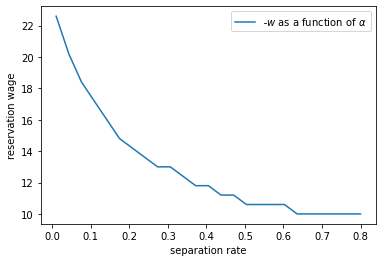

In [13]:
grid_size = 25

α_vals = np.linspace(0.01, 0.8, grid_size)
γ_vals = np.linspace(0.4, 0.99, grid_size)
σ_vals = np.linspace(0.5, 3.0, grid_size)
wmax_vals = np.linspace(20, 60, grid_size)
c_vals = np.linspace(5, 20, grid_size)
p_vals = np.linspace(0.1, 0.9, grid_size)


# your code here
w_bar_vals1 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, α in enumerate(α_vals):
    mcm.α = α
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals1[i] = w_bar

ax.set(xlabel='separation rate', ylabel='reservation wage')
ax.plot(α_vals, w_bar_vals1, label=r'$\bar w$ as a function of $\alpha$')
ax.legend()

plt.show()

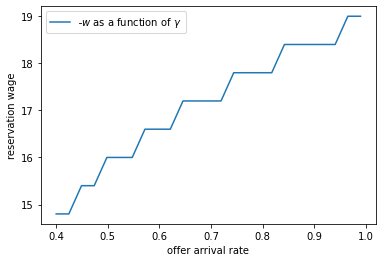

In [14]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.c=6
p=0.5


w_bar_vals2 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, γ in enumerate(γ_vals):
    mcm.γ = γ
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals2[i] = w_bar

ax.set(xlabel='offer arrival rate', ylabel='reservation wage')
ax.plot(γ_vals, w_bar_vals2, label=r'$\bar w$ as a function of $\gamma$')
ax.legend()

plt.show()

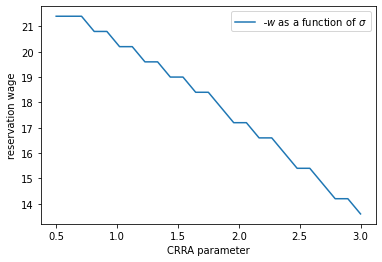

In [15]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.c=6
p=0.5

w_bar_vals3 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, σ in enumerate(σ_vals):
    mcm.σ = σ
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals3[i] = w_bar

ax.set(xlabel='CRRA parameter', ylabel='reservation wage')
ax.plot(σ_vals, w_bar_vals3, label=r'$\bar w$ as a function of $\sigma$')
ax.legend()

plt.show()

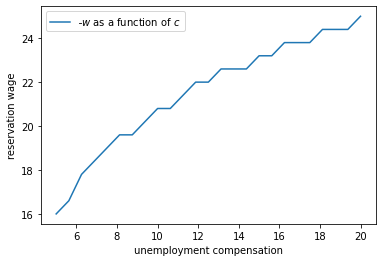

In [16]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.c=6
p=0.5

w_bar_vals4 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, c in enumerate(c_vals):
    mcm.c = c
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals4[i] = w_bar

ax.set(xlabel='unemployment compensation', ylabel='reservation wage')
ax.plot(c_vals, w_bar_vals4, label=r'$\bar w$ as a function of $c$')
ax.legend()

plt.show()

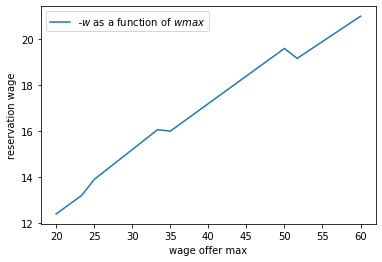

In [17]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.c=6
p=0.5

w_bar_vals5 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, wmaxx in enumerate(wmax_vals):
    wmax_prime = wmaxx
    w_prime = np.linspace(wmin, wmax_prime, n+1)
    mcm.w_vec = w_prime
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals5[i] = w_bar

ax.set(xlabel='wage offer max', ylabel='reservation wage')
ax.plot(wmax_vals, w_bar_vals5, label=r'$\bar w$ as a function of $wmax$')
ax.legend()

plt.show()

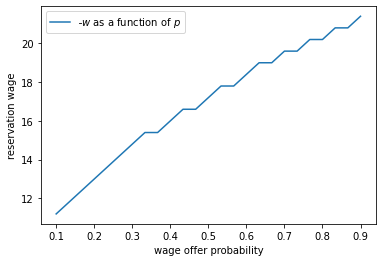

In [18]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5

w_bar_vals6 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, pp in enumerate(p_vals):
    p_prime = pp
    q_prime = binom.pmf(range(n+1),n, p_prime)
    mcm.q_vec = q_prime
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals6[i] = w_bar

ax.set(xlabel='wage offer probability', ylabel='reservation wage')
ax.plot(p_vals, w_bar_vals6, label=r'$\bar w$ as a function of $p$')
ax.legend()

plt.show()

### Q.1-8: Unemployment Rate in the Steady State

Show how the steady state unemployment rates change as the model parameters change. 

- Use the values for parameters as in Q.1-7.
- compute steady state unemployment rates and plot the results

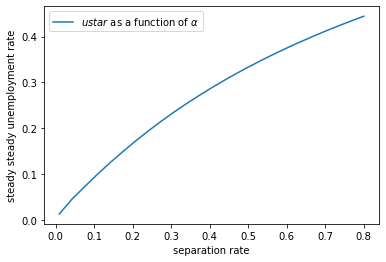

In [19]:
# your code here
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

u_star_vals1 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, α in enumerate(α_vals):
    mcm.α = α
    u_star = steady_state_unemployment(mcm, w_bar_vals1[i])
    u_star_vals1[i] = u_star


ax.set(xlabel='separation rate', ylabel='steady steady unemployment rate')
ax.plot(α_vals, u_star_vals1, label=r'$u star$ as a function of $\alpha$')
ax.legend()

plt.show()

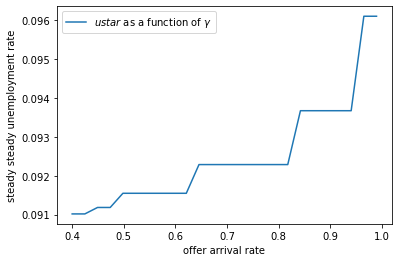

In [20]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

u_star_vals2 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, γ in enumerate(γ_vals):
    mcm.γ = γ
    u_star = steady_state_unemployment(mcm, w_bar_vals2[i])
    u_star_vals2[i] = u_star


ax.set(xlabel='offer arrival rate', ylabel='steady steady unemployment rate')
ax.plot(γ_vals, u_star_vals2, label=r'$u star$ as a function of $\gamma$')
ax.legend()

plt.show()

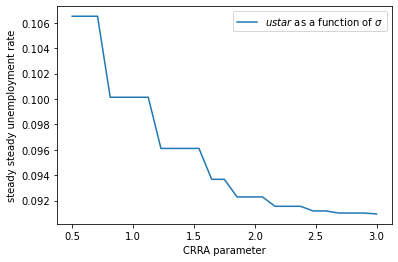

In [21]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

u_star_vals3 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, σ in enumerate(σ_vals):
    mcm.σ = σ
    u_star = steady_state_unemployment(mcm, w_bar_vals3[i])
    u_star_vals3[i] = u_star


ax.set(xlabel='CRRA parameter', ylabel='steady steady unemployment rate')
ax.plot(σ_vals, u_star_vals3, label=r'$u star$ as a function of $\sigma$')
ax.legend()

plt.show()

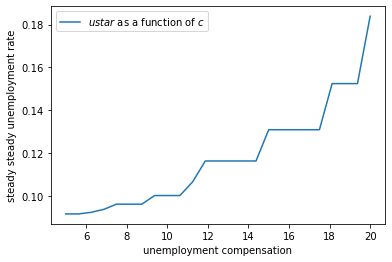

In [22]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

u_star_vals4 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, c in enumerate(c_vals):
    mcm.c = c
    u_star = steady_state_unemployment(mcm, w_bar_vals4[i])
    u_star_vals4[i] = u_star


ax.set(xlabel='unemployment compensation', ylabel='steady steady unemployment rate')
ax.plot(c_vals, u_star_vals4, label=r'$u star$ as a function of $c$')
ax.legend()

plt.show()

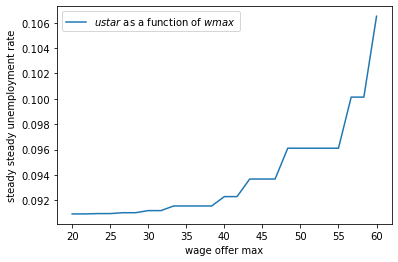

In [23]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

u_star_vals5 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, wmax2 in enumerate(wmax_vals):
    wmax_prime = wmax2
    w_prime = np.linspace(wmin, wmax_prime, n+1)
    mcm.w_vec = w_prime
    u_star = steady_state_unemployment(mcm, w_bar_vals5[i])
    u_star_vals5[i] = u_star


ax.set(xlabel='wage offer max', ylabel='steady steady unemployment rate')
ax.plot(wmax_vals, u_star_vals5, label=r'$u star$ as a function of $wmax$')
ax.legend()

plt.show()

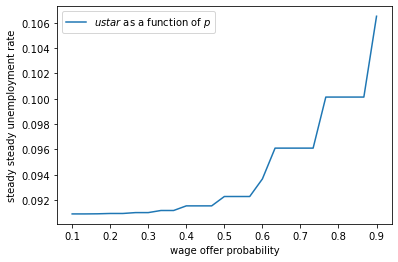

In [24]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

u_star_vals6 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, p2 in enumerate(p_vals):
    p_prime = p2
    q_prime = binom.pmf(range(n+1),n, p_prime)
    mcm.q_vec = q_prime
    u_star = steady_state_unemployment(mcm, w_bar_vals6[i])
    u_star_vals6[i] = u_star


ax.set(xlabel='wage offer probability', ylabel='steady steady unemployment rate')
ax.plot(p_vals, u_star_vals6, label=r'$u star$ as a function of $p$')
ax.legend()

plt.show()

### Q.1-9: Average Unemployment Duration

Show how the average unemployment durations change as the model parameters change. 

- Use the values for parameters as in Q.1-7.
- compute steady state unemployment rates and plot the results

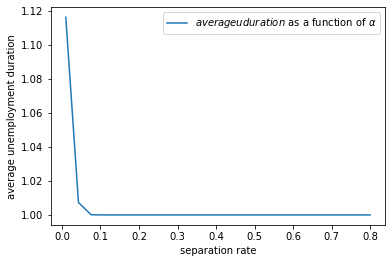

In [25]:
# your code here
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

duration_vals1 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, α in enumerate(α_vals):
    mcm = McCallModel(α=α)
    duration = compute_average_unemployment_duration(w_bar_vals1[i])
    duration_vals1[i] = duration


ax.set(xlabel='separation rate', ylabel='average unemployment duration')
ax.plot(α_vals, duration_vals1, label=r'$average u duration$ as a function of $\alpha$')
ax.legend()

plt.show()


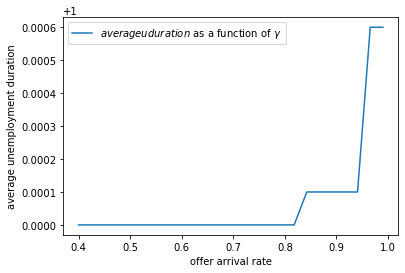

In [26]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

duration_vals2 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, γ in enumerate(γ_vals):
    mcm = McCallModel(γ=γ)
    duration = compute_average_unemployment_duration(w_bar_vals2[i])
    duration_vals2[i] = duration


ax.set(xlabel='offer arrival rate', ylabel='average unemployment duration')
ax.plot(γ_vals, duration_vals2, label=r'$average u duration$ as a function of $\gamma$')
ax.legend()

plt.show()

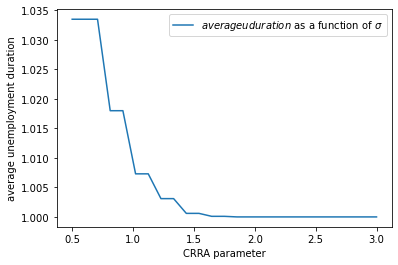

In [27]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

duration_vals3 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, σ in enumerate(σ_vals):
    mcm = McCallModel(σ=σ)
    duration = compute_average_unemployment_duration(w_bar_vals3[i])
    duration_vals3[i] = duration


ax.set(xlabel='CRRA parameter', ylabel='average unemployment duration')
ax.plot(σ_vals, duration_vals3, label=r'$average u duration$ as a function of $\sigma$')
ax.legend()

plt.show()


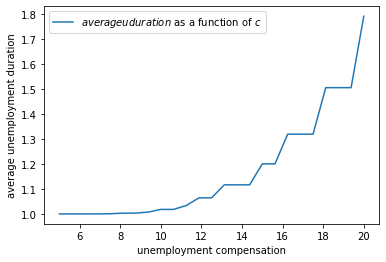

In [28]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

duration_vals4 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c)
    duration = compute_average_unemployment_duration(w_bar_vals4[i])
    duration_vals4[i] = duration


ax.set(xlabel='unemployment compensation', ylabel='average unemployment duration')
ax.plot(c_vals, duration_vals4, label=r'$average u duration$ as a function of $c$')
ax.legend()

plt.show()

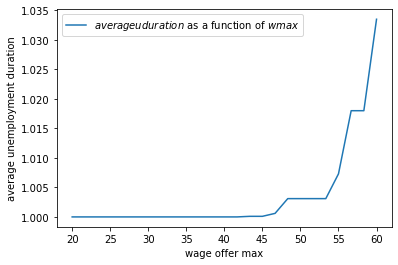

In [29]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

duration_vals5 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, wmax3 in enumerate(wmax_vals):
    wmax_prime = wmax3
    w_prime = np.linspace(wmin, wmax_prime, n+1)
    mcm = McCallModel(w_vec=w_prime)
    duration = compute_average_unemployment_duration(w_bar_vals5[i])
    duration_vals5[i] = duration


ax.set(xlabel='wage offer max', ylabel='average unemployment duration')
ax.plot(wmax_vals, duration_vals5, label=r'$average u duration$ as a function of $wmax$')
ax.legend()

plt.show()

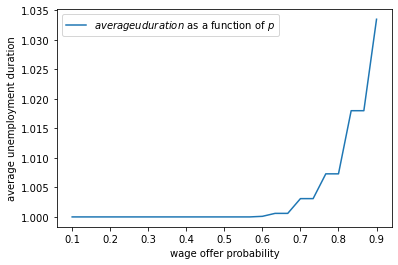

In [30]:
mcm.α=0.1
mcm.γ=0.7
mcm.σ=2
wmax=40
mcm.w_vec = w
mcm.c=6
p=0.5
mcm.q_vec = q

duration_vals6 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, p3 in enumerate(p_vals):
    p_prime = p3
    q_prime = binom.pmf(range(n+1),n, p_prime)
    mcm = McCallModel(q_vec=q_prime)
    duration = compute_average_unemployment_duration(w_bar_vals6[i])
    duration_vals6[i] = duration


ax.set(xlabel='wage offer probability', ylabel='average unemployment duration')
ax.plot(p_vals, duration_vals6, label=r'$average u duration$ as a function of $p$')
ax.legend()

plt.show()

## Question 2: Continuous and Correlated Wage Offers



### The model

Each period, an employed worker faces a probability $\alpha$ of getting laid off and becoming unemployed. If she survives the exogenous job separation, her wage changes according to a stochastic process of which transition probability distribution is given as $Q(w,w')=\mathrm{P}(w_{t+1}\le w'|w_t = w)$. Observing the wage change, an employed worker has two options:
1. Continues to work at the new wage $w'$: Stay employed
1. Quit the current job and search for a new job: Become unemployed.

For simplicity, assume that an unemployed worker is given UI benefits in the amount of $c$ and receives the wage offer $ \tilde{w} = \displaystyle{\int} w\, d\tilde{Q}(w) $ with a probability $0 < \gamma < 1$, where $\tilde{Q}(w')$ is the marginal distribution associated with $Q(\cdot, w')$. Since no other wage offers will be given, an nemployed worker immediately accepts the wage offer $ \tilde{w} $ once receving it and becomes employed. 

The value of being employed at wage $w$ and the value of being unemployed can be written as follow, respectively:  
<a id='value_V2'></a>
$$
V(w) = u(w) + \beta \Big[ (1-\alpha) \int \max\left\{V(w'), U\right\} q(w,w') dw' + \alpha U \Big] \tag{3}
$$

and

<a id='value_U2'></a>
$$
U = u(c) + \beta \left[(1-\gamma) U + \gamma V(\tilde{w}) \right] \tag{4}
$$

This setup is basically the same optimal stopping time problem. However it is now an **employed** worker's decision of quitting the current job instead of an unemployed worker's decision of taking a new job.

### Q.2-1: Define the class that describes the model economy

Write the class **QuitModel** assuming that wages follow the following AR(1) process: 

$$
\log{w_{t+1}} = \mu + \rho \log{w_t} + 
\epsilon_{t+1}, \qquad \epsilon_{t+1}\sim N(0,s)
$$. 

The contents of the class are similar to those in the class **McCallModel** in Q.1-2. 

- specify types of the variables that are used in the class in `quit_data`
- a function `__init__`: sets the default values for the data.
    - $\alpha = 0.1$: job separation rate
    - $\beta = 0.98$: discount factor
    - $\gamma = 0.7$: offer arrival rate
    - $\mu = 0$: drift term in AR(1) process of wages
    - $\rho = 0.9$: persistence of AR(1) process of wages
    - $s = 0.1$: variance of innovation in AR(1) process of wages
    - $\sigma = 2$: CRRA parameter
    - $c = 6$: unemployment compensation
    - grid_size = 100: length of wage grid vector
    - mc_size = 1,000: Monte Carlo draws for integration
- a function `u`: computes CRRA utility with parameter $\sigma$
- a function `update`: take V and U in the current as inputs and updates them according to equation (3) and (4) 
- jit-compile the class with `@jitclass`


In [31]:
# your code here
quit_data = [
     ('α', float64),             # job separation rate
     ('β', float64),             # discount factor
     ('γ', float64),             # offer arrival rate
     ('μ', float64),             # drift term in AR(1) process of wages
     ('ρ', float64),             # persistence of AR(1) process of wages
     ('s', float64),             # variance of innovation in AR(1) process of wages
     ('σ', float64),             # CRRA parameter
     ('c', float64),             # unemployment compensation
     ('w_grid', float64[:]),     # grid over the state space
     ('e_draws', float64[:])   # Monte Carlo draws for integration
]



In [32]:
from numpy.random import randn
from interpolation import interp

In [33]:
#@jitclass(quit_data)
class QuitModel:

    def __init__(self,
                 α = 0.1,
                 β= 0.98,
                 γ=0.7,
                 μ=0.0,
                 ρ=0.9,
                 s=0.1,       
                 σ=2,       
                 c=6,        
                 mc_size=1000,
                 grid_size=100):

        self.α, self.β, self.γ, self.μ, self.ρ, self.s, self.σ, self.c = α, β, γ, μ, ρ, s, σ, c

        # Set up grid
        z_mean =  (μ/np.sqrt(s))/ (1 - ρ)
        z_sd = np.sqrt(1/ (1 - ρ**2))
        k = 3  # std devs from mean
        a, b = z_mean - k * z_sd, z_mean + k * z_sd
        w_min = np.exp(a*np.sqrt(s))
        w_max = np.exp(b*np.sqrt(s))
        self.w_grid = np.linspace(w_min, w_max, grid_size)

        # Draw and store shocks
        np.random.seed(1234)
        self.e_draws = randn(1, mc_size)

    
    def u(self, c, σ):
        if c > 0:
            return (c**(1 - σ) - 1) / (1 - σ)
        else:
            return -10e6

    
    def update(self, V, U):
        """
        A jitted function to update the Bellman equations.  Note that V_new is
        modified in place (i.e, modified by this function).  The new value of U
        is returned.

        """
        α, β, γ, μ, ρ, s, σ, c = self.α, self.β, self.γ, self.μ, self.ρ, self.s, self.σ, self.c
        u = self.u
        
        M = self.e_draws.shape[1]
        V_new = np.empty_like(V)
        
        VF = lambda x: interp(self.w_grid, V, x)
        w_tilda = np.exp(μ/(1-ρ))
        w = w_tilda
        z=(1/np.sqrt(s))*np.log(w)
        expectation = 0.0
        
        for m in range(M):
            e1 = self.e_draws[:,m]
            z_next = (μ/np.sqrt(s)) + ρ * z + e1
            w_next = np.exp(z_next * np.sqrt(s))     # w' draw
            expectation += np.maximum(VF(w_next), U)
        expectation = expectation / M
        
        d = u(w_tilda, σ) + β * ((1 - α) * expectation + α * U)
        U_new = u(c, σ) + β * (1 - γ) * U + β * γ * d

        
        
        for i in range(len(self.w_grid)):
            w = self.w_grid[i]
            z = (1/np.sqrt(s))*np.log(w)
            expectation = 0.0
            
            for m in range(M):
                e1 = self.e_draws[:,m]
                z_next = (μ/np.sqrt(s)) + ρ * z + e1
                w_next = np.exp(z_next * np.sqrt(s))     # w' draw
                expectation += np.maximum(VF(w_next), U)
            expectation = expectation / M
            V_new[i] = u(w, σ) + β * ((1 - α) * expectation + α * U)
            
        return V_new, U_new

### Q.2-2: Solve Value Functions through Iteration

- Write a function `solve_model` that iterates the value functions V and U until they converge to their fixed points.
- jit-compile the function with `@njit`- Create an instance `qm` of the class `QuitModel` with the default values.
- solve for the fixed points of V and U.
- plot the converged V and U.


In [34]:
# your code here
#@njit
def solve_model(qm, tol=1e-5, max_iter=20):
    """
    Iterates to convergence on the Bellman equations

    Parameters
    ----------
    qm : an instance of McCallModel
    tol : float
        error tolerance
    max_iter : int
        the maximum number of iterations
    """

    V = np.ones(len(qm.w_grid))  # Initial guess of V
    U = 1                        # Initial guess of U
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        V_new, U_new = qm.update(V, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1

    return V, U



In [35]:
qm = QuitModel()
V, U = solve_model(qm)

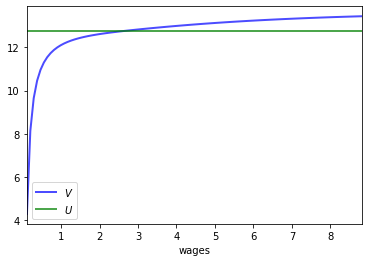

In [36]:
fig, ax = plt.subplots()

ax.plot(qm.w_grid, V, 'b-', lw=2, alpha=0.7, label='$V$')
ax.plot(qm.w_grid, [U] * len(qm.w_grid), 'g-', lw=2, alpha=0.7, label='$U$')
ax.set_xlim(min(qm.w_grid), max(qm.w_grid))
ax.set_xlabel('wages')
ax.legend()

plt.show()

### Q.2-3: Reservation Wage

- Write a function `compute_reservation_wage` to compute the reservation wage for the model economy using `brentq` from `quantecon.optimize`.
- jit-compile the class with `@njit`
- execute the function to show the reservation wage. 

In [37]:
from scipy import optimize
def compute_reservation_wage(qm):
    u = qm.u
    V, U = solve_model(qm)
    
    def VF0(x):
        A = V-U
        aa = interp(qm.w_grid, A, x)
        return aa
    w_bar = optimize.brentq(VF0, min(qm.w_grid), max(qm.w_grid))
    
    return w_bar

In [38]:
w_bar = compute_reservation_wage(qm)
w_bar

2.6954303127735635

### Q.2-4: Comparative Statics: Reservation Wage

Show how reservation wages change as the model parameters change. 

- Use the values for parameters below.
- compute reservation wages and plot the results

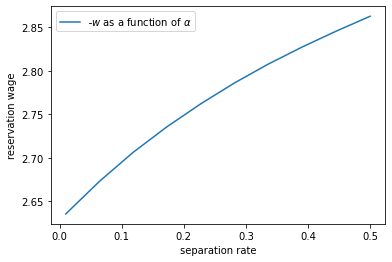

In [39]:
grid_size = 10

α_vals = np.linspace(0.01, 0.5, grid_size)
γ_vals = np.linspace(0.4, 0.9, grid_size)
μ_vals = np.linspace(-0.2, 0.2, grid_size)
s_vals = np.linspace(0.02, 0.2, grid_size)
c_vals = np.linspace(2, 8, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)


# your code here
w_bar_vals1 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, α in enumerate(α_vals):
    qm.α = α
    w_bar = compute_reservation_wage(qm)
    w_bar_vals1[i] = w_bar

ax.set(xlabel='separation rate', ylabel='reservation wage')
ax.plot(α_vals, w_bar_vals1, label=r'$\bar w$ as a function of $\alpha$')
ax.legend()

plt.show()



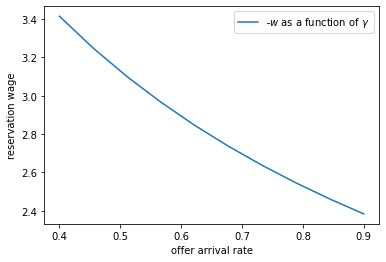

In [40]:
qm.α=0.1
qm.γ=0.7
qm.μ=0
qm.s =0.1
qm.c=6
qm.β=0.98


w_bar_vals2 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, γ in enumerate(γ_vals):
    qm.γ = γ
    w_bar = compute_reservation_wage(qm)
    w_bar_vals2[i] = w_bar

ax.set(xlabel='offer arrival rate', ylabel='reservation wage')
ax.plot(γ_vals, w_bar_vals2, label=r'$\bar w$ as a function of $\gamma$')
ax.legend()

plt.show()

In [41]:
def compute_reservation_wage1(qm):
    """
    Computes the reservation wage of an instance of the quit model
    by finding the smallest w such that v(w) >= U

    If no such w exists, then w_bar is set to np.inf.
    compute_reservation_wage로 μ_vals에 관한 그림을 그릴 수 없어 compute_reservation_wage1 함수 사용
    """

    V, U = solve_model(qm)

    w_bar = np.inf
    for i, wage in enumerate(qm.w_grid):
        if V[i] > U:
            w_bar = wage
            break

    return w_bar

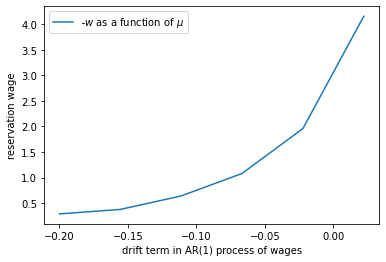

In [42]:
qm.α=0.1
qm.γ=0.7
qm.μ=0
qm.s =0.1
qm.c=6
qm.β=0.98


w_bar_vals3 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, μ in enumerate(μ_vals):
    qm.μ = μ
    w_bar = compute_reservation_wage1(qm)
    w_bar_vals3[i] = w_bar

ax.set(xlabel='drift term in AR(1) process of wages', ylabel='reservation wage')
ax.plot(μ_vals, w_bar_vals3, label=r'$\bar w$ as a function of $\mu$')
ax.legend()

plt.show()

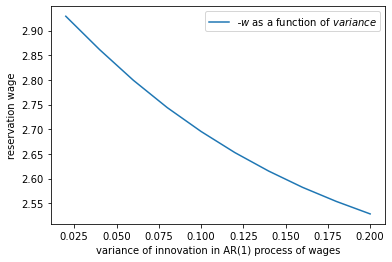

In [43]:
qm.α=0.1
qm.γ=0.7
qm.μ=0
qm.s =0.1
qm.c=6
qm.β=0.98


w_bar_vals4 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, s in enumerate(s_vals):
    qm.s = s
    w_bar = compute_reservation_wage(qm)
    w_bar_vals4[i] = w_bar

ax.set(xlabel='variance of innovation in AR(1) process of wages', ylabel='reservation wage')
ax.plot(s_vals, w_bar_vals4, label=r'$\bar w$ as a function of $variance$')
ax.legend()

plt.show()

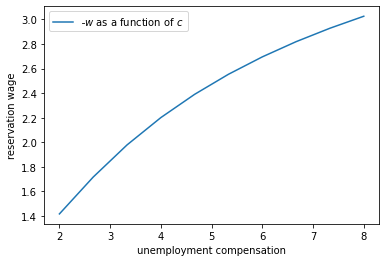

In [44]:
qm.α=0.1
qm.γ=0.7
qm.μ=0
qm.s =0.1
qm.c=6
qm.β=0.98


w_bar_vals5 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, c in enumerate(c_vals):
    qm.c = c
    w_bar = compute_reservation_wage(qm)
    w_bar_vals5[i] = w_bar

ax.set(xlabel='unemployment compensation', ylabel='reservation wage')
ax.plot(c_vals, w_bar_vals5, label=r'$\bar w$ as a function of $c$')
ax.legend()

plt.show()

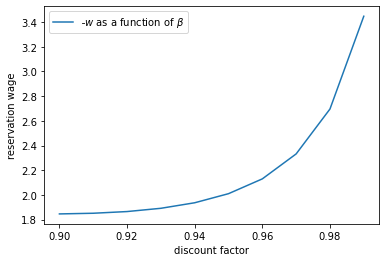

In [45]:
qm.α=0.1
qm.γ=0.7
qm.μ=0
qm.s =0.1
qm.c=6
qm.β=0.98


w_bar_vals6 = np.empty_like(c_vals)
fig, ax = plt.subplots()

for i, β in enumerate(β_vals):
    qm.β = β
    w_bar = compute_reservation_wage(qm)
    w_bar_vals6[i] = w_bar

ax.set(xlabel='discount factor', ylabel='reservation wage')
ax.plot(β_vals, w_bar_vals6, label=r'$\bar w$ as a function of $\beta$')
ax.legend()

plt.show()